In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Satıcılar

🎯 Amacımız, diğerlerine göre tekrarlı olarak düşük performans gösteren satıcıları bulmak ve nedenini anlamaktır.  
Bu, Olist'in gelecekte kâr marjını artırmaya yönelik önerilerimizi şekillendirmemize yardımcı olacaktır.

## 1 - `olist/seller.py`  

`order.py` ile benzer bir süreçte, size `olist/seller.py` modülünü sunduk; içinde `Seller` sınıfı ve `Seller().get_training_data` yöntemi bulunuyor. Bu yöntem aşağıdaki özellikleri içeren bir DataFrame döndürür:

| feature_name | type | açıklama |
| --- | --- | --- |
| `seller_id` | str | satıcının benzersiz kimliği (UNIQUE) |
| `seller_city` | str | satıcının bulunduğu şehir |
| `seller_state` | str | satıcının bulunduğu eyalet |
| `delay_to_carrier` | float | sipariş, `shipping_limit_date`'den önce teslim edildiyse 0 döner; aksi takdirde gecikme süresini verir |
| `wait_time` | float | satıcı başına ortalama teslimat süresi (bekleme süresi) |
| `date_first_sale` | datetime | Olist üzerinde yapılan ilk satışın tarihi |
| `date_last_sale` | datetime | Olist üzerindeki son satışın tarihi |
| `months_on_olist` | float | Olist'te geçirilen yaklaşık ay sayısı |
| `share_of_five_stars` | float | satıcının yer aldığı siparişlerdeki beş yıldız değerlendirmelerinin oranı |
| `share_of_one_stars` | float | satıcının yer aldığı siparişlerdeki bir yıldız değerlendirmelerinin oranı |
| `review_score` | float | satıcının yer aldığı siparişler için ortalama değerlendirme puanı |
| `n_orders` | int | satıcının yer aldığı benzersiz sipariş sayısı |
| `quantity` | int | bu satıcı tarafından satılan toplam ürün adedi |
| `quantity_per_order` | float | bu satıcı için sipariş başına ortalama ürün sayısı |
| `sales` | float | bu satıcı ile ilişkili toplam satış tutarı (kargo hariç), BRL cinsinden |

❓ **Aşağıya yeni sınıfınızı import edin ve eğitim veri çerçevenizi inceleyin!** Kodları incelemek için zaman ayırın ve sizin için tam olarak nelerin hesaplandığını anlayın.

In [2]:
from olist.seller import Seller

# Eğitim veri setini oluştur
sellers = Seller().get_training_data()

# İlk kontrol
sellers.head()


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99


🤔 Her satıcı için henüz hesaplanması gereken bir şey kaldı:
- Aşırı yüksek değerlendirmelerin oranı (`share_of_five_stars`) ve aşırı düşük değerlendirmelerin oranı (`share_of_one_stars`)
- (ortalama) `review_score`

😱 Düşük puanlı her sipariş Olist'in itibarına olumsuz etki yapar; bu etki `cost_of_review` ile modellenir.

Bu, daha sonra her satıcı için toplam `cost_of_review`'u hesaplamamıza yardımcı olacak!

❓ **Sizin doldurmanız gereken son metod: `get_review_score()`'u implemente edin.**

In [27]:
from olist.seller import Seller

sellers = Seller().get_training_data()
sellers.head()


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,share_of_five_stars,share_of_one_stars
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,3.000000,0.333333,0.333333
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,4.560976,0.731707,0.048780
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,1.000,158.00,5.000000,1.000000,0.000000
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,1.000,79.99,5.000000,1.000000,0.000000
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,1.000,167.99,1.000000,0.000000,1.000000


🧪 Kodunuzu aşağıda test edin

In [20]:
from nbresult import ChallengeResult

tmp = Seller().get_training_data()
result = ChallengeResult('seller',
    shape = tmp.shape,
    median = tmp.review_score.median(),
    columns = tmp.columns
)
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /Users/dilay/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /Users/dilay/Desktop/data-sellers/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_seller.py::TestSeller::test_column_names PASSED                     [ 33%]
test_seller.py::TestSeller::test_median_review_score PASSED              [ 66%]
test_seller.py::TestSeller::test_shape PASSED                            [100%]

============================== 3 passed in 0.76s ===============================


💯 You can commit your code:

git add tests/seller.pickle

git commit -m 'Completed seller step'

git push origin master



💡 **Tam satır sayısını elde edemiyor musunuz?**
<details><summary>Fazladan 3 satır mı var?</summary>
Left veya right join mi yaptınız? Nedenini anlıyoruz; fakat burada sadece değerlendirme alan satıcılarla ilgileniyoruz; bu yüzden inner join kullandık.
</details>
<details><summary>2 satır mı eksik?</summary>
`Orders().get_training_data()`'ı mı kullandınız? Bu geçerli bir seçenek, fakat sadece değerlendirmelerle ilgileniyorsak biraz aşırı olabilir. O method birçok hesaplama yapar ve döndürdüğü sütunların çoğuna ihtiyaç duymuyoruz. İhtiyacımıza daha uygun başka bir `Order` methodu bulun.
</details>

⚠️ `olist` reposundaki `seller.py` dosyasına yaptığınız kod değişikliklerini commit etmeyi unutmayın!

## 2 - Satıcıları İnceleme

### (2.1) Görselleştirmeler

Bu satıcılar hakkında ilk ***`EDA - Keşifsel Veri Analizi`*** ile başlayalım.

👉 `sellers` için özet istatistiklere bakın. Satıcı başına siparişlerin medyanı nedir ❓

In [21]:
sellers["n_orders"].median()

7.0

👉 Bir sonraki adımda, veri setindeki her sayısal değişkenin dağılımını tek bir büyük görselde çizeceğiz. 

Kod size verildi, hücreyi çalıştırmanız yeterli.

- 👀 Herhangi bir aykırı değer fark ediyor musunuz?
- Sipariş sayısının dağılımı nasıl görünüyor ❓

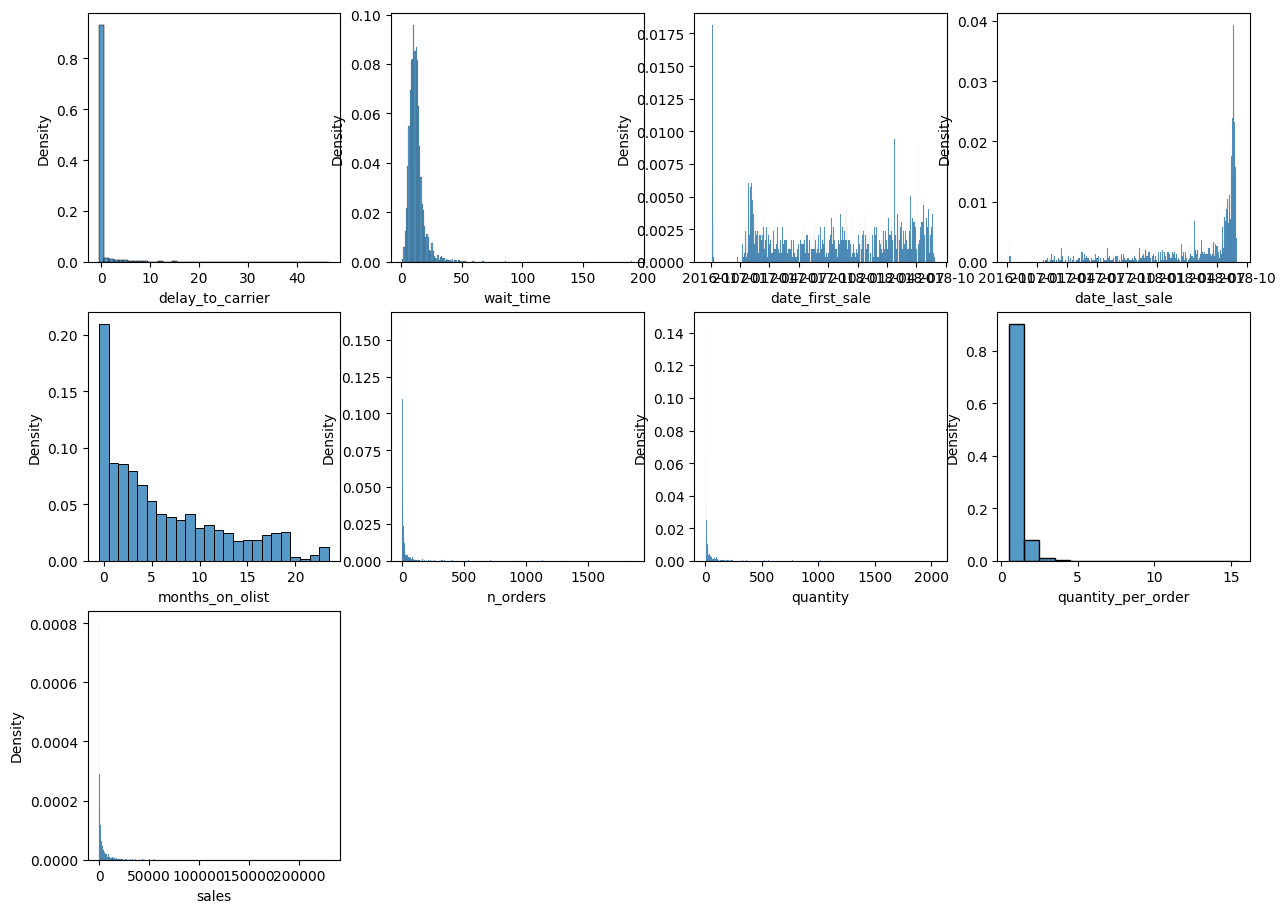

In [22]:
plt.figure(figsize=(15,11))
for (i, col) in enumerate(sellers.describe().columns):#["wait_time", "delay_to_carrier", "avg_review_score", "n_orders", "quantity", "price"]):
    plt.subplot(3,4,i+1)
    sns.histplot(sellers[col], kde=False, stat='density', discrete=[True,None][col in ['share_of_one_stars','share_of_five_stars','sales']]);

💡 Çok düşük değerlendirme puanlarına sahip bir grup satıcının öne çıktığı görünüyor!

📊 Grafiksel olarak inceleyelim:
- `plotly` kullanarak `delay_to_carrier` ile `wait_time` arasındaki ilişkiyi gösteren bir saçılma grafiği (scatterplot) oluşturuyoruz; kabarcık boyutunu satıcının toplam `sales`'i, rengini ise `review_score` belirliyor.

`plotly`'ı daha sonra detaylı göreceğiz; şimdilik aşağıdaki hücreyi çalıştırın.

In [31]:
sellers.columns


Index(['seller_id', 'seller_city', 'seller_state', 'delay_to_carrier',
       'wait_time', 'date_first_sale', 'date_last_sale', 'months_on_olist',
       'n_orders', 'quantity', 'quantity_per_order', 'sales', 'review_score',
       'share_of_five_stars', 'share_of_one_stars'],
      dtype='object')

In [28]:
# Notebook uyumluluğu için kolon adı sabitleme
if "review_score" not in sellers.columns:
    sellers["review_score"] = sellers["avg_review_score"]


In [29]:
import plotly.express as px
fig = px.scatter(data_frame = sellers[sellers['review_score'] < 4],
    x="wait_time",
    y="delay_to_carrier",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5
)
fig.show()

En kötü satıcıları bulmak için `x`, `y`, `color` ve `size` değerlerini değiştirmekten çekinmeyin.

### (2.2) `review_score`'u OLS ile modelleme

⚠️ Saçılma grafikleri veriyi görsel olarak analiz etmemizi sağlar, fakat sınırlamaları vardır: deneme-yanılma içerir ve ilişkileri yalnızca niteliksel değerlendiririz.

💡 **Satıcıların `review_score`** değişkenini açıklamak için daha sağlam bir yöntem, `statsmodels` içinde **çok değişkenli (multivariate) OLS** kullanarak çeşitli özelliklerin `review_score` üzerindeki etkisini modellemektir.

İstediğiniz sayısal özellikleri kullanarak bir OLS oluşturalım.

👉 Regresyon katsayılarını karşılaştırabilmek için önce aşağıdaki `standardize` fonksiyonunu kullanarak özelliklerinizi standardize edin.

In [30]:
def standardize(df, features):
    """Standardize specified numerical features in a DataFrame using z-score.

    Parameters
    ----------
    df : pandas.DataFrame
        Input dataframe.
    features : list of str
        List of column names to standardize.

    Returns
    -------
    pandas.DataFrame
        A copy of the original dataframe where the specified features have been
        standardized to zero mean and unit variance. Other columns are left
        unchanged.
    """
    df_standardized = df.copy()
    mu = df[features].mean()
    sigma = df[features].std()
    df_standardized[features] = (df[features] - mu) / sigma
    return df_standardized

In [34]:
sellers_standardized = standardize(sellers, features)


👉 Sonraki adımda bir OLS modeli oluşturun ve fit edin.

In [35]:
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()

❓ En etkili özellikler hangileri?

👉 Sıralanmış katsayılarla bir 📊 `bar_plot` çizin.

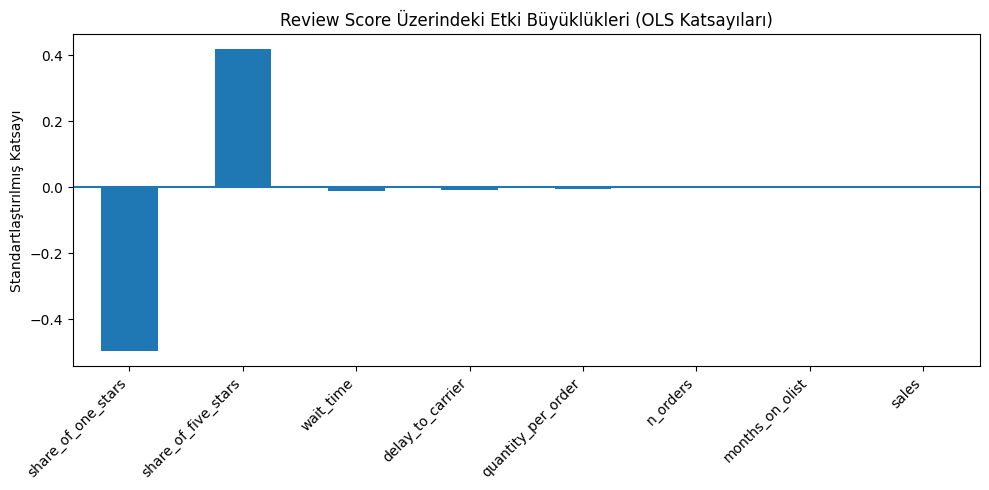

In [36]:
coef = model.params.drop("Intercept")

# Mutlak değere göre sırala
coef_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)

# Bar plot
plt.figure(figsize=(10, 5))
coef_sorted.plot(kind="bar")
plt.axhline(0)
plt.title("Review Score Üzerindeki Etki Büyüklükleri (OLS Katsayıları)")
plt.ylabel("Standartlaştırılmış Katsayı")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


👉 Son olarak modelinizin performansını (`R-squared`) ve `residuals`'ı inceleyin

In [37]:

print("R-squared:", model.rsquared)


R-squared: 0.9427087037298563


👉 Gerçek değerlendirme puanlarını ve modelin tahmin ettiği puanları aynı grafikte göstererek karşılaştırın.

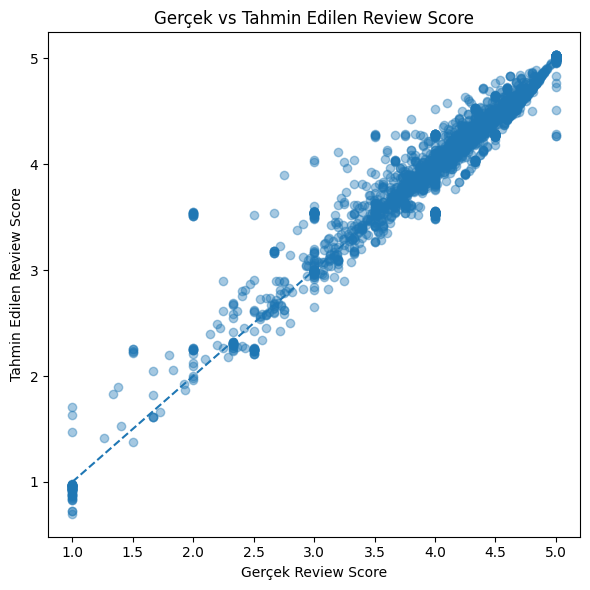

In [38]:
y_true = sellers["review_score"]
y_pred = model.predict(sellers_standardized)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         linestyle="--")
plt.xlabel("Gerçek Review Score")
plt.ylabel("Tahmin Edilen Review Score")
plt.title("Gerçek vs Tahmin Edilen Review Score")
plt.tight_layout()
plt.show()


👉 Artıkları (residuals) görselleştirin

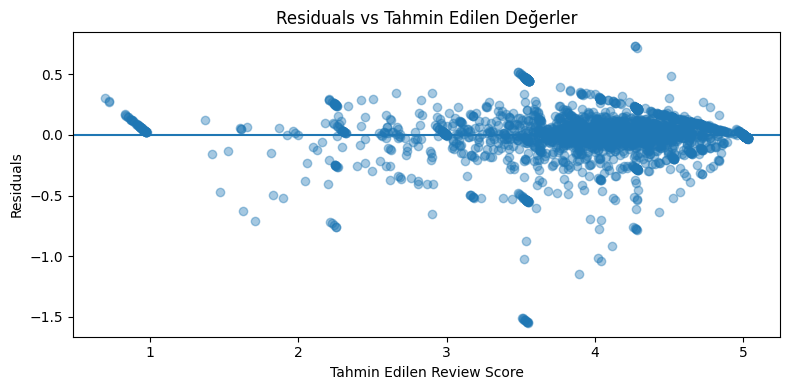

In [39]:
residuals = y_true - y_pred

plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0)
plt.xlabel("Tahmin Edilen Review Score")
plt.ylabel("Residuals")
plt.title("Residuals vs Tahmin Edilen Değerler")
plt.tight_layout()
plt.show()


### (2.3) Analize `seller_state` bilgisini ekleyin

❓ Henüz `seller_state` bilgisini kullanmadık.  
- Sadece `seller_state`'lere karşı `review_score`'u regresyonla modelleyen yeni bir OLS oluşturun.
- `olist/utils.py` içinde sizin için yazılmış olan `return_significative_coef(model)` fonksiyonunu kullanarak anlamlı (significant) özellikleri analiz edin.
- `review_score` açısından en iyi eyaletler hangileri?

<details>
    <summary>- İpuçları -</summary>
        
⚠️ Dikkat, `seller_state` kategorik bir özelliktir. 
    
💡 Formülde kategorik değişkenleri belirtmek için `C(a_cat_feature)` kullanın. Bu, her benzersiz kategori için bir boolean değişken (`is_cat_feature_xx`) oluşturacaktır.

</details>

In [40]:
import statsmodels.formula.api as smf
from olist.utils import return_significative_coef

# seller_state kategorik → dummy olarak otomatik modele girer
state_model = smf.ols(
    formula="review_score ~ C(seller_state)",
    data=sellers
).fit()

# Model özeti (istersen bak)
state_model.summary()

# Anlamlı (significant) katsayılar
significant_states = return_significative_coef(state_model)

significant_states


,variable,p_value,coef
0,Intercept,0.004692,2.333333
16,C(seller_state)[T.RN],0.017234,2.152614
4,C(seller_state)[T.ES],0.015239,2.047204
8,C(seller_state)[T.MS],0.030525,1.955000
11,C(seller_state)[T.PB],0.029107,1.944444
9,C(seller_state)[T.MT],0.041997,1.875631
19,C(seller_state)[T.SC],0.028167,1.815788
14,C(seller_state)[T.PR],0.029643,1.796951
5,C(seller_state)[T.GO],0.033207,1.779274
7,C(seller_state)[T.MG],0.031453,1.778586


☝️ Bazı eyaletlerin ortalama olarak diğerlerinden _anlamlı_ biçimde daha iyi değerlendirmelere sahip olduğu görülebilir.

🤔 Bu, daha düşük `quantity_per_order`, daha kısa `wait_time` veya `delay_to_carrier`'dan mı kaynaklanıyor? Yoksa elimizde olmayan başka faktörlerden mi?

❓ **`seller_state` etkisini diğerlerinden izole etmeye çalışın: OLS modelinize sürekli (continuous) diğer özellikleri ekleyin; `seller_state` artık istatistiksel olarak anlamlı olmayana kadar devam edin!**

In [41]:
continuous_features = [
    "quantity_per_order",
    "wait_time",
    "delay_to_carrier",
    "months_on_olist",
    "n_orders",
    "sales"
]

base_formula = "review_score ~ C(seller_state)"
current_formula = base_formula

models = {}

for feature in continuous_features:
    current_formula = current_formula + f" + {feature}"
    model = smf.ols(formula=current_formula, data=sellers).fit()
    models[feature] = model
    
    print(f"\n=== Model with {feature} added ===")
    print(return_significative_coef(model))



=== Model with quantity_per_order added ===
                 variable       p_value      coef
0               Intercept  2.330342e-03  2.504828
16  C(seller_state)[T.RN]  1.628671e-02  2.162659
4   C(seller_state)[T.ES]  1.384358e-02  2.068134
8   C(seller_state)[T.MS]  2.970897e-02  1.956805
11  C(seller_state)[T.PB]  2.788592e-02  1.951590
9   C(seller_state)[T.MT]  4.037621e-02  1.883095
19  C(seller_state)[T.SC]  2.433576e-02  1.855431
14  C(seller_state)[T.PR]  2.689895e-02  1.821169
5   C(seller_state)[T.GO]  2.904741e-02  1.816547
18  C(seller_state)[T.RS]  2.867193e-02  1.805057
7   C(seller_state)[T.MG]  2.863507e-02  1.802091
1   C(seller_state)[T.BA]  3.479512e-02  1.781857
12  C(seller_state)[T.PE]  3.989812e-02  1.779665
15  C(seller_state)[T.RJ]  3.387715e-02  1.748560
21  C(seller_state)[T.SP]  3.406212e-02  1.741934
3   C(seller_state)[T.DF]  3.967486e-02  1.718217
22     quantity_per_order  6.533261e-07 -0.171495

=== Model with wait_time added ===
              varia

In [42]:
final_model = models["wait_time"]

final_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     27.74
Date:                Thu, 25 Dec 2025   Prob (F-statistic):          8.89e-108
Time:                        18:51:43   Log-Likelihood:                -3345.1
No. Observations:                2967   AIC:                             6738.
Df Residuals:                    2943   BIC:                             6882.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.7799      0.757      6.317      0.000       3.296       6.264
C(seller_state)[T.BA]     0.2607      0.773      0.337      0.736      -1.256       1.777
C(seller_state)[T.CE]     0.0019      0.783      0.002      0.998      -1.533       1.537
C(seller_state)[T.DF]     0.0631      0.766      0.082      0.934      -1.438       1.564
C(seller_state)[T.ES]     0.3795      0.770      0.493      0.622      -1.131       1.890
C(seller_state)[T.GO]     0.2207      0.763      0.289      0.772      -1.275       1.716
C(seller_state)[T.MA]     0.2393      1.063      0.225      0.822      -1.844       2.323
C(seller_state)[T.MG]     0.1290      0.755      0.171      0.864      -1.351       1.609
C(seller_state)[T.MS]     0.2180      0.825      0.264      0.792      -1.400       1.835
C(seller_state)[T.MT]     0.2838      0.841      0.337      0.736      -1.366       1.933
C(seller_state)[T.PA]     0.5257      1.063      0.495      0.621      -1.559       2.610
C(seller_state)[T.PB]     0.2596      0.813      0.319      0.750      -1.335       1.854
C(seller_state)[T.PE]     0.1476      0.794      0.186      0.852      -1.409       1.704
C(seller_state)[T.PI]     0.1263      1.063      0.119      0.905      -1.958       2.211
C(seller_state)[T.PR]     0.1089      0.755      0.144      0.885      -1.371       1.589
C(seller_state)[T.RJ]     0.0259      0.756      0.034      0.973      -1.456       1.508
C(seller_state)[T.RN]     0.4556      0.825      0.552      0.581      -1.162       2.073
C(seller_state)[T.RO]     0.0545      0.921      0.059      0.953      -1.751       1.860
C(seller_state)[T.RS]     0.1645      0.756      0.218      0.828      -1.318       1.647
C(seller_state)[T.SC]     0.1869      0.755      0.247      0.805      -1.294       1.668
C(seller_state)[T.SE]    -0.0881      0.921     -0.096      0.924      -1.895       1.719
C(seller_state)[T.SP]     0.0204      0.754      0.027      0.978      -1.458       1.498
quantity_per_order       -0.1655      0.031     -5.266      0.000      -0.227      -0.104
wait_time                -0.0477      0.002    -24.199      0.000      -0.052      -0.044
==============================================================================
Omnibus:                      732.445   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2634.957
Skew:                          -1.195   Prob(JB):                         0.00
Kurtosis:                       6.950   Cond. No.                     3.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.64e+03. This might indicate that there are

☝️ Analize `wait_time` ekledikten sonra, 22 adet `is_seller_state_xx` dummy değişkeninin hiçbirinin istatistiksel olarak anlamlı olmadığı görüldü:

Küçük veri setimiz göz önüne alındığında (çoğu eyalette çok az sayıda satıcı var):
- "Bazı eyaletlerin, `wait_time` dışındaki nedenlerle doğal olarak diğerlerinden daha iyi olduğu" sonucuna _varamayız_.
- Başka bir deyişle, "`seller_state`'in `wait_time` dışında `review_score` üzerinde etkisi yoktur" hipotezini reddedemeyiz.

🏁 Tebrikler!

💾 Commit ve push yapın:
- `sellers.ipynb` not defterinizi
- ayrıca `seller.py` dosyanızı